In [2]:
import pandas as pd
import numpy as np
import os.path as op
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

In [3]:
year = 1995
images = np.memmap(op.join("monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
images = np.divide(images,255)
label_df = pd.read_feather(op.join("monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
label_df.head()

,Date,StockID,EWMA_vol,Retx,Retx_5d,Retx_20d,Retx_60d,Retx_week,Retx_month,Retx_quarter,...,Ret_week,Ret_month,Ret_quarter,Ret_5d,Ret_20d,Ret_60d,Ret_65d,Ret_180d,Ret_250d,Ret_260d
0,1995-01-31,10001,0.001369,0.026915,1.612871e-02,4.695394e-07,-0.026210,NaN,-2.620911e-02,NaN,...,NaN,-2.620911e-02,NaN,1.612871e-02,4.695394e-07,-0.014274,-0.020396,0.087523,0.184191,0.285693
1,1995-02-28,10001,0.001550,-0.026210,-6.211224e-03,2.691370e-02,0.043475,NaN,-6.212548e-03,NaN,...,NaN,5.969362e-03,NaN,-6.211224e-03,3.950167e-02,0.056266,0.005968,0.133974,0.285552,0.285553
2,1995-03-31,10001,0.001092,-0.032258,-4.422044e-08,1.000002e-01,0.066665,-4.422044e-08,1.537173e-07,0.099998,...,-4.422044e-08,1.537173e-07,0.113331,-4.422044e-08,1.000002e-01,0.079594,0.045857,0.243387,0.326651,0.291740
3,1995-04-28,10001,0.001122,-0.006211,9.999954e-02,2.081826e-03,0.033331,9.999954e-02,4.999837e-02,NaN,...,9.999954e-02,4.999837e-02,NaN,9.999954e-02,2.081826e-03,0.045856,0.096461,0.208847,0.204460,0.204460
4,1995-05-31,10001,0.002389,0.000000,4.761905e-02,-1.587307e-02,0.015872,NaN,4.761887e-02,NaN,...,NaN,6.031686e-02,NaN,6.031705e-02,-3.944643e-03,0.028185,0.028185,0.151284,0.196981,0.130481


In [11]:
images =[]
label_df= pd.DataFrame()
for year in range(1993,2000):
    train = np.memmap(op.join("monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r+').reshape(\
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    train = np.array(train/255.0)
    images.append(train)
    label_df_train = pd.read_feather(op.join("monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
    label_df= pd.concat([label_df,label_df_train],axis= 0)
images = np.concatenate(images, axis=0, out=None)
type(images)

numpy.ndarray

In [84]:
x_test =[]
y_test= pd.DataFrame()
for year in range(2000,2020):
    train = np.memmap(op.join("monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r+').reshape(\
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    train = np.array(train/255.0)
    x_test.append(train)
    label_df_train = pd.read_feather(op.join("monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
    y_test= pd.concat([y_test,label_df_train],axis= 0)
x_test = np.concatenate(x_test, axis=0, out=None)
y_test = y_test['Retx_20d'].copy()
y_test[ y_test >0.0]=1.0
y_test[ y_test <=0.0]=0.0
y_test[y_test.isna()] = 2.0
x_test = np.reshape(x_test,( -1,1,64,60))
y_test = np.array(y_test).reshape((-1,1))

(694871, 64, 60)
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


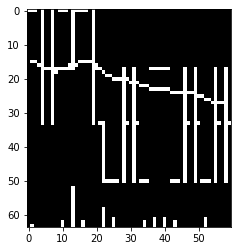

In [12]:
print(images.shape)
print(images[0])
plt.imshow(images[0], cmap='gray')
plt.show()

In [13]:
y = label_df['Retx_20d'].copy()
y[ y >0.0]=1.0
y[ y <=0.0]=0.0
y[y.isna()] = 2.0
y = np.array(y).reshape((-1,1))


In [14]:
images = np.reshape(images,( -1,1,64,60))
x_train, x_val, y_train, y_val = train_test_split(images, y, test_size=0.3, random_state=10, shuffle=True)

print('shape train:',np.shape(x_train),'shape validation',np.shape(x_val),'shape test',np.shape(x_test))

shape train: (486409, 1, 64, 60) shape validation (208462, 1, 64, 60) shape test (825705, 1, 64, 60)


In [5]:
import torch
from torch.utils import data # 获取迭代数据
from torch.autograd import Variable # 获取变量
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.utils.data as Dataset
from torchsummary import summary
torch.cuda.empty_cache()   

In [6]:
class subDataset(Dataset.Dataset):
    #初始化，定义数据内容和标签
    def __init__(self, Data, Label):
        self.Data = Data
        self.Label = Label
    #返回数据集大小
    def __len__(self):
        return len(self.Data)
    #得到数据内容和标签
    def __getitem__(self, index):
        data = torch.Tensor(self.Data[index])
        label = torch.Tensor(self.Label[index])
        return data, label

In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        print(self.path)
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [85]:
train_dataset = subDataset(x_train, y_train)
val_dataset = subDataset(x_val, y_val)
test_dataset = subDataset(x_test, y_test)

In [86]:
train_loader = data.DataLoader(train_dataset,batch_size=128,shuffle=True)
val_loader= data.DataLoader(val_dataset,batch_size=128,shuffle=True)
test_loader = data.DataLoader(test_dataset,batch_size=128,shuffle=False)

In [11]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1,
                            out_channels=64,
                            kernel_size=[5,3],
                            stride=[1,3],
                            padding=[2,1],                            
                            dilation =[1,2]
                            ),
            torch.nn.BatchNorm2d(64),
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d((2, 1))
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64,128, kernel_size=[5,3], padding=[2,1],  stride=[1,3]),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d((2, 1))
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(128,256, kernel_size=[5,3], padding=[2,1],  stride=[1,3]),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d((2, 1))
        )
        self.flatten = nn.Flatten()
        self.fc1 = torch.nn.Linear(256*8*3,3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # x = x.view(x.shape[0], -1)
        x = self.flatten(x)
        x = self.fc1(x)
        return x


In [12]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_ids=range(torch.cuda.device_count())
print(device_ids)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs")
# dim = 0 [64, xxx] -> [32, ...], [32, ...] on 2GPUs
model = nn.DataParallel(model, device_ids=device_ids)
model.cuda(device=device_ids[0]) 


range(0, 4)
Let's use 4 GPUs


DataParallel(
  (module): CNN(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1), dilation=(1, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [13]:
patience= 10
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=0.00001)
early_stopping = EarlyStopping(patience, path= '../cnn_model/cnn_torch/ret_20_checkpoint.pt',verbose=True)

../cnn_model/cnn_torch/ret_20_checkpoint.pt


In [14]:
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        print(m)
        nn.init.xavier_normal_(m.weight.data)
        # nn.init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)

Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1), dilation=(1, 2))
Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1))
Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1))


In [ ]:
loss_count = []
patience = 10
epochs = 120
global_loss_train = []
global_loss_test = []
global_acc_train = []
global_acc_test = []
for epoch in range(epochs):
    for i,(x,y) in enumerate(train_loader):
        batch_x = Variable(x.cuda(device=device_ids[0])) # torch.Size([128,1,64,60])
        batch_y = Variable(y.cuda(device=device_ids[0])) # torch.Size([128,3])
        # 获取最后输出
        out = model(batch_x.float()) # torch.Size([128,3])
        # print(np.shape(out))
        # 获取损失
        loss = loss_func(out,batch_y.squeeze().long())

        opt.zero_grad()  # 
        loss.backward() # 误差反向传播，计算参数更新值
        opt.step() # 将参数更新值施加到net的parmeters上
        if i%20 == 0:
            temp = loss.cpu()
            loss_count.append(temp.detach().numpy())
            print('epoch: {}: '.format(epoch+1),'iteration: {}:\t'.format(i+1),'loss:', loss.item())
            torch.save(model.state_dict(),r'../cnn_model/cnn_torch/ret_20_checkpoint.pt')

        if i % 100 == 0:
            for a,b in val_loader:
                val_x = Variable(a.cuda(device=device_ids[0]))
                val_y = Variable(b.cuda(device=device_ids[0]))
                out = model(val_x)
                # print('test_out:\t',torch.max(out,1)[1])
                # print('test_y:\t',test_y)
                accuracy = torch.max(out,1)[1].cpu().numpy() == val_y.cpu().numpy()
                print('accuracy:\t',accuracy.mean())
                break
    early_stopping(loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        # 结束模型训练
        break
    if epoch % 1 == 0:
        print('----------------epoch end---------------------', epoch)
        prediction_train = model(batch_x)
        loss_train = loss_func(prediction_train, batch_y.squeeze().long())
        global_loss_train.append(loss_train.cpu().detach().numpy())
        train_acc = torch.max(prediction_train,1)[1].cpu().numpy() == batch_y.cpu().numpy()
        global_acc_train.append(train_acc.mean())
        print('|loss_train|', loss_train.cpu().item(), '|train_acc|', train_acc.mean())
        for a,b in test_loader:
            test_x = Variable(a.cuda(device=device_ids[0]))
            test_y = Variable(b.cuda(device=device_ids[0]))
            prediction_test = model(test_x)
            loss_test = loss_func(prediction_test, test_y.squeeze().long())
            global_loss_test.append(loss_test.cpu().detach().numpy())
            acc_test = torch.max(prediction_test,1)[1].cpu().numpy() == test_y.cpu().numpy()
            global_acc_test.append(acc_test.mean())
            print('|loss_test|', loss_test.cpu().item(), '|test_acc|', acc_test.mean())
            break     
        

model.load_state_dict(torch.load('../cnn_model/cnn_torch/ret_20_checkpoint.pt'))
plt.figure('PyTorch_CNN_Loss')
plt.plot(loss_count,label='Loss')
plt.legend()
plt.show()

In [ ]:
epochs = range(1, len(global_acc_test) + 1)

plt.plot(epochs, global_acc_train, 'bo', label='Train')
plt.plot(epochs, global_acc_test, 'r', label='test')
plt.title('acc')
plt.legend()
plt.figure()
plt.plot(epochs, global_loss_train, 'bo', label='Train')
plt.plot(epochs, global_loss_test, 'r', label='test')
plt.legend()
plt.title('loss')
plt.show()


In [87]:
model.load_state_dict(torch.load('../cnn_model/cnn_torch/ret_20_checkpoint.pt'))
global_loss_test = []
global_acc_test = []
prediction = []
y_res = []
for a,b in test_loader:
    test_x = Variable(a.cuda(device=device_ids[0]))
    test_y = Variable(b.cuda(device=device_ids[0]))
    prediction_test = model(test_x)
    loss_test = loss_func(prediction_test, test_y.squeeze().long())
    global_loss_test.append(loss_test.cpu().detach().numpy())
    acc_test = torch.max(prediction_test,1)[1].cpu().numpy() == test_y.cpu().numpy()
    global_acc_test.append(acc_test.mean())
    prediction.extend(torch.max(prediction_test,1)[1].cpu().numpy().tolist())
    y_res.extend(np.array(b).tolist())
    print('|loss_test|', loss_test.cpu().item(), '|test_acc|', acc_test.mean())


|loss_test| 0.7615926265716553 |test_acc| 0.4610595703125
|loss_test| 0.7415123581886292 |test_acc| 0.486083984375
|loss_test| 0.7435385584831238 |test_acc| 0.4716796875
|loss_test| 0.7391979098320007 |test_acc| 0.47149658203125
|loss_test| 0.7911962270736694 |test_acc| 0.4801025390625
|loss_test| 0.7367377877235413 |test_acc| 0.485107421875
|loss_test| 0.750188946723938 |test_acc| 0.45184326171875
|loss_test| 0.7807497978210449 |test_acc| 0.462890625
|loss_test| 0.7074629664421082 |test_acc| 0.4901123046875
|loss_test| 0.7208510637283325 |test_acc| 0.47998046875
|loss_test| 0.7553316950798035 |test_acc| 0.4947509765625
|loss_test| 0.7161892056465149 |test_acc| 0.48095703125
|loss_test| 0.6903257369995117 |test_acc| 0.481689453125
|loss_test| 0.7227856516838074 |test_acc| 0.4853515625
|loss_test| 0.7039279341697693 |test_acc| 0.48681640625
|loss_test| 0.7047051191329956 |test_acc| 0.4652099609375
|loss_test| 0.7505475878715515 |test_acc| 0.44635009765625
|loss_test| 0.8166419267654419 

In [1]:
print('|loss_test|', np.mean(global_loss_test), '|test_acc|', np.mean(global_acc_test))
loss_res = np.mean(global_loss_test)
acc_res = np.mean(global_acc_test)

In [92]:
print('|loss_test|', loss_res, '|test_acc|', acc_res)

|loss_test| 0.7375448441505432 |test_acc| 0.5146968666171965


In [78]:
print(np.shape(np.array(prediction).reshape((-1,1))))
print(np.shape(np.array(y_res).reshape((-1,1))))

/tmp/ipykernel_25372/1488444999.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.shape(np.array(prediction).reshape((-1,1))))
/tmp/ipykernel_25372/1488444999.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.shape(np.array(y_res).reshape((-1,1))))


(6451, 1)
(6451, 1)


In [88]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
Accuracy_Score = accuracy_score(prediction, y_res)

In [89]:
Accuracy_Score

0.5082380071405604